In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# Tullock original

In [2]:
b1, b2, v1, v2 = sp.symbols('b_1 b_2 v_1 v_2')

a = 1/2

x1 = b1**a / (b1**a + b2**a)
x2 = b2**a / (b1**a + b2**a)

u1 = v1 * x1 - b1
u2 = v2 * x2 - b2
u2

b_2**0.5*v_2/(b_1**0.5 + b_2**0.5) - b_2

In [3]:
part1 = sp.simplify(sp.diff(u1, b1))
part2 = sp.simplify(sp.diff(u2, b2))
part2

0.5*b_1**0.5*v_2/(b_2**0.5*(b_1**0.5 + b_2**0.5)**2) - 1

In [4]:
func1 = sp.lambdify([b1, b2], part1.evalf(subs={v1:11.}))
func2 = sp.lambdify([b1, b2], part2.evalf(subs={v2:1.}))

In [5]:
def eqs(p):
    b1, b2 = p
    return [func1(b1, b2), func2(b1, b2)]

sol = fsolve(eqs, (0.49, 0.12))
sol, sol[0]/sol[1], sum(sol)

(array([0.97897236, 0.08899749]), 10.99999999989627, 1.0679698490599445)

# Tullock prop pay

In [6]:
b1, b2, v1, v2 = sp.symbols('b_1 b_2 v_1 v_2')

a = 1/2

x1 = b1**a / (b1**a + b2**a)
x2 = b2**a / (b1**a + b2**a)

u1 = (v1 - b1) * x1
u2 = (v2 - b2) * x2
u2

b_2**0.5*(-b_2 + v_2)/(b_1**0.5 + b_2**0.5)

In [7]:
part1 = sp.simplify(sp.diff(u1, b1))
part2 = sp.simplify(sp.diff(u2, b2))
part2

(0.5*b_2**0.5*(b_2 - v_2) - b_2**1.0*(b_1**0.5 + b_2**0.5) + 0.5*(b_1**0.5 + b_2**0.5)*(-b_2 + v_2))/(b_2**0.5*(b_1**0.5 + b_2**0.5)**2)

In [8]:
func1 = sp.lambdify([b1, b2], part1.evalf(subs={v1:11.}))
func2 = sp.lambdify([b1, b2], part2.evalf(subs={v2:1.}))

In [9]:
def eqs(p):
    b1, b2 = p
    return [func1(b1, b2), func2(b1, b2)]

sol = fsolve(eqs, (0.49, 0.12))
sol, sol[0]/sol[1], sum(sol)

(array([1.42974385, 0.25959133]), 5.507671713758218, 1.6893351806651935)

# Two-player welfare loss scaling

In [10]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [64]:
costs   = np.arange(1, 4, 0.05)
guesses = np.arange(1, 4, 0.05)

In [65]:
res2player = []
for i in range(len(costs)):
    curCost = [1,costs[i]]
    bids  = getEquilBids(curCost, a=3, guess=[guesses[i],guesses[i]])
    allos = getAllos(bids, a=3)
    res2player.append([np.dot(curCost, allos), np.dot(bids, allos), bids[0], bids[1], allos[0], allos[1]])
res2player = np.array(res2player)
res2player.shape

(60, 6)

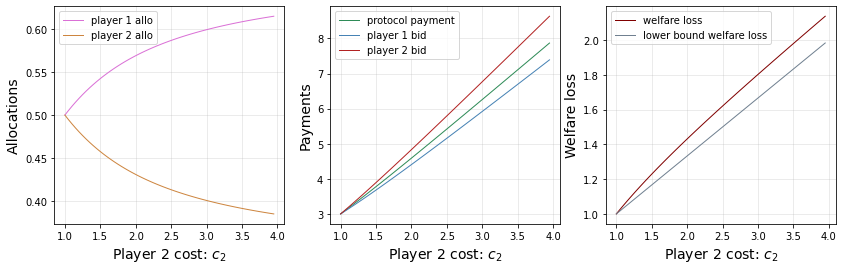

In [66]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

axarr[0].plot(costs, res2player[:,4], color='orchid', label='player 1 allo', fillstyle='none', 
              linestyle='-', linewidth=1)
axarr[0].plot(costs, res2player[:,5], color='peru', label='player 2 allo', fillstyle='none', 
              linestyle='-', linewidth=1)


axarr[1].plot(costs, res2player[:,1], color='seagreen', label='protocol payment', fillstyle='none', 
              linestyle='-', linewidth=1)
# axarr[1].plot([costs[0], costs[-1]], [res2player[0,1], res2player[-1,1]], color='seagreen', linestyle='--',
#               linewidth=1, label='linear', alpha=0.3)
axarr[1].plot(costs, res2player[:,2], color='steelblue', label='player 1 bid', fillstyle='none', 
              linestyle='-', linewidth=1)
axarr[1].plot(costs, res2player[:,3], color='firebrick', label='player 2 bid', fillstyle='none', 
              linestyle='-', linewidth=1)


axarr[2].plot(costs, res2player[:,0], color='maroon', label='welfare loss', fillstyle='none', linestyle='-',
              linewidth=1)
# axarr[2].plot([costs[0], costs[-1]], [res2player[0,0], res2player[-1,0]], color='maroon', linestyle='--',
#               linewidth=1, alpha=0.3)
axarr[2].plot(costs, (costs+3-1)/3, color='slategray', label='lower bound welfare loss', 
              fillstyle='none', linestyle='-', linewidth=1)

for ax in axarr:
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'Player 2 cost: $c_2$', size=14)
axarr[0].set_ylabel(r'Allocations', size=14)
axarr[1].set_ylabel(r'Payments', size=14)
axarr[2].set_ylabel(r'Welfare loss', size=14)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# alpha scales payments non-monotonically

In [87]:
alphas = [3,4,5,6,7,8,9,10]
loAnz  = [2.0, 8.0, 8.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [16., 17., 17., 3.0, 3.0, 3.0, 3.0, 3.0]
n      = 10

c16Res = []
for i,a in enumerate(alphas):
    print(i, a)
    costs = [1]
    guess = [loAnz[i]]

    costs.extend([16]*n)
    guess.extend([hiAnz[i]]*n)

    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    c16Res.append([np.dot(costs, allos), np.dot(bids, allos), bids[0], bids[1], allos[0], allos[1]])
c16Res = np.array(c16Res)
c16Res.shape

0 3
1 4
2 5
3 6
4 7
5 8
6 9
7 10


(8, 6)

In [88]:
c16Res[-1][4] + c16Res[-1][5]*10

0.9999999999248163

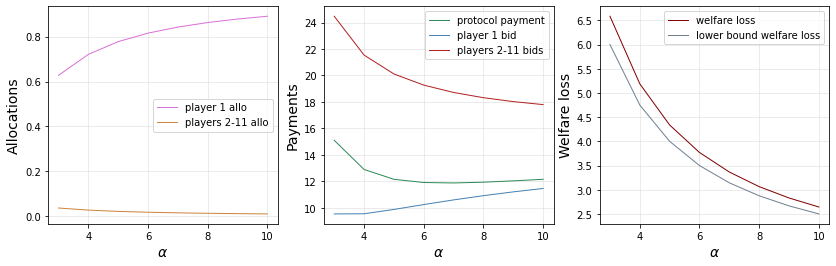

In [97]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

axarr[0].plot(alphas, c16Res[:,4], color='orchid', label='player 1 allo', fillstyle='none', 
              linestyle='-', linewidth=1)
axarr[0].plot(alphas, c16Res[:,5], color='peru', label='players 2-11 allo', fillstyle='none', 
              linestyle='-', linewidth=1)


axarr[1].plot(alphas, c16Res[:,1], color='seagreen', label='protocol payment', fillstyle='none', 
              linestyle='-', linewidth=1)
axarr[1].plot(alphas, c16Res[:,2], color='steelblue', label='player 1 bid', fillstyle='none', 
              linestyle='-', linewidth=1)
axarr[1].plot(alphas, c16Res[:,3], color='firebrick', label='players 2-11 bids', fillstyle='none', 
              linestyle='-', linewidth=1)


axarr[2].plot(alphas, c16Res[:,0], color='maroon', label='welfare loss', fillstyle='none', linestyle='-',
              linewidth=1)
axarr[2].plot(alphas, (16+np.array(alphas)-1)/np.array(alphas), color='slategray', 
              label='lower bound welfare loss', fillstyle='none', linestyle='-', linewidth=1)

for ax in axarr:
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$\alpha$', size=14)
axarr[0].set_ylabel(r'Allocations', size=14)
axarr[1].set_ylabel(r'Payments', size=14)
axarr[2].set_ylabel(r'Welfare loss', size=14)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

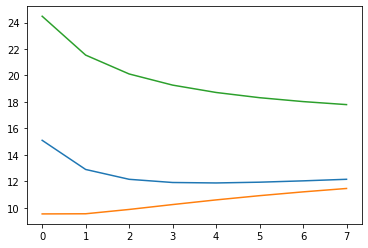

In [76]:
# plt.plot(c16Welfare)
plt.plot(c16Res[:,1])
plt.plot(c16Res[:,2])
plt.plot(c16Res[:,3])